In [1]:
# Refer all the libraries used in this program
import warnings
warnings.filterwarnings('ignore')
import re
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
# Some useful information about the load balancer log from AWS
'''
server_ip = '-',if load balancer can't send the request to a registered instance, or
                if instance closes the connection before a response or instance does not respond before the idle timeout
lb_server_time = -1,if the load balancer can't dispatch the request to a registered instance or
                    if the registered instance closes the connection or if the client sends a malformed request or
                    if the client establishes a connection with the load balancer but does not send any data or
                    if the registered instance does not respond before the idle timeout
server_backend_time = -1, if the load balancer can't dispatch the request to a registered instance or
                          if the registered instance closes the connection or if the client sends a malformed request or
                          if the registered instance does not respond before the idle timeout
lb_client_response_time = -1, if the load balancer can't dispatch the request to a registered instance or
                              if the registered instance closes the connection or if the client sends a malformed request or
                              if the registered instance does not respond before the idle timeout
client_request :  format: HTTP Method + Protocol://Host header:port + Path + HTTP version
user_agent : Agent that identifies the client that originated the request. It consists of one or more product identifiers, product[/version]
ssl_cipher = -1, otherwise the value is recorded if the incoming SSL/TLS connection was established after a successful negotiation
ssl_protocol = -1, otherwise the value is recorded if the incoming SSL/TLS connection was established after a successful negotiation
'''

# Load the load balancer log into a dataframe
df = pd.read_csv('./unzip/web_log_sample.log', sep=" ", error_bad_lines=False, header = None, index_col=False,
                   names=('request_time', 'lb_name', 'client_ip', 'server_ip', 'lb_server_request_time', 'server_backend_time',
                          'lb_client_response_time', 'lb_status_code', 'server_status_code', 'client_request_size',
                          'server_rsponse_size', 'client_request', 'user_agent', 'ssl_cipher', 'ssl_protocol'))

# df['request_time'] = pd.to_datetime(df['request_time'])
# df['request_time'] = df['request_time'].str.split('.', 1).str[0].astype('datetime64[ns]')

# Convert the request time to native python datetime data type
df['request_time'] = df['request_time'].astype('datetime64[ns]')

# Strip the port number of the client's machine, as this may not add value in the current context
df['client_ip'] = df['client_ip'].str.split(':', 1).str[0]

# Set the request time as index for the data frame
df.set_index('request_time', inplace=True)

In [3]:
from IPython.display import display
# The original data count and a few sample rows
display(df.head())
print('The number of log entries are {}'.format(len(df)))

,lb_name,client_ip,server_ip,lb_server_request_time,server_backend_time,lb_client_response_time,lb_status_code,server_status_code,client_request_size,server_rsponse_size,client_request,user_agent,ssl_cipher,ssl_protocol
request_time,,,,,,,,,,,,,,
2015-07-22 09:00:28.019143,marketpalce-shop,123.242.248.130,10.0.6.158:80,0.000022,0.026109,0.000020,200,200,0,699,GET https://paytm.com:443/shop/authresponse?co...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2
2015-07-22 09:00:27.894580,marketpalce-shop,203.91.211.44,10.0.4.150:80,0.000024,0.153340,0.000026,200,200,0,1497,GET https://paytm.com:443/shop/wallet/txnhisto...,Mozilla/5.0 (Windows NT 6.1; rv:39.0) Gecko/20...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2
2015-07-22 09:00:27.885745,marketpalce-shop,1.39.32.179,10.0.4.244:80,0.000024,0.164958,0.000017,200,200,0,157,GET https://paytm.com:443/shop/wallet/txnhisto...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2
2015-07-22 09:00:28.048369,marketpalce-shop,180.179.213.94,10.0.6.108:80,0.000020,0.002333,0.000021,200,200,0,35734,GET https://paytm.com:443/shop/p/micromax-yu-y...,-,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2
2015-07-22 09:00:28.036251,marketpalce-shop,120.59.192.208,10.0.4.217:80,0.000024,0.015091,0.000016,200,200,68,640,POST https://paytm.com:443/papi/v1/expresscart...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2


The number of log entries are 1158500


In [4]:
# The dataset is large for single processor laptop, so a sample with 100,000 requests was taken
# It is time series dataset, so the sample was taken as a continuous block, without shuffling
df_sample = df[0:100000]

In [5]:
# Function transforms IP address to a long integer before feeding into learning algorithms
# Here the dots are removed and each integer is added with 100 to make it 3 fixed digits and concatenate them together
# For example, 1.2.3.4 is transformed into 101102103104
# Similarly 102.36.45.203 is transformed to 202136145303
def transform_ip(ip_add):
    ip_add_tran = int(''.join(map(str,list(map(lambda x:int(x)+100, re.findall(r"[\w']+", ip_add))))))
    return ip_add_tran

## Sessionize by IP addresses and aggregrate page hits within 15 minutes

In [6]:
# Routine to sessionize the web log with max session time as 15 minutes
# Dataframes to hold the data after computations
df_sess = pd.DataFrame({'client_ip' : [], 'sess_start' : [], 'sess_end' : [], 'resp_time' : [], 'sess_time' : [], 
                        'sess_class' : [], 'sess_id' : [], 'client_ip_flat' : []})
df_sess_url = pd.DataFrame({'sess_id' : [], 'client_ip' : [], 'client_request' : []})

# Initialize flags and counts
j_sess = 1
new_sess = 0

# Iterate on every client or IP
for ip in pd.unique(df_sample['client_ip'].values.ravel()):    
    i = 0
    len_date = len(df_sample.index[df_sample['client_ip'] == ip])
    # Iterate on every request from the given IP
    for ix, req_dt in enumerate(df_sample.index[df_sample['client_ip'] == ip]):  
        if i == 0:
            curr_dt = req_dt
        
        # Verify the client's last request within 15 minutes and populate the dataframe with session information
        if pd.Timedelta(req_dt - curr_dt).seconds / 60.0 > 15:
            new_sess = 1
            resp_t = 0
            # Add all the response times, unless it is a bad request with -1
            if df_sample['lb_server_request_time'][ix] > 0:
                resp_t = df_sample['lb_server_request_time'][ix] + df_sample['server_backend_time'][ix] + df_sample['lb_client_response_time'][ix]
            # Compute session time and add response time of last request to complete the session
            sess_t = pd.Timedelta(prev_req_dt - curr_dt).seconds/60
            sess_t = sess_t + resp_t
            # Update session class with labels, splitting sessions with below 20 seconds and above 20 seconds
            if sess_t <= 0.333:
                sess_c = 0
            else:
                sess_c = 1
            # Transform IP address by calling the function
            ip_tran = transform_ip(ip)
            
            df_sess = df_sess.append({'client_ip': ip, 'sess_start': curr_dt, 'sess_end': prev_req_dt,
                                     'resp_time' : resp_t, 'sess_time' : sess_t, 'sess_id' : j_sess,
                                     'sess_class' : sess_c, 'client_ip_flat' : ip_tran}, ignore_index=True)
            curr_dt = req_dt
            
        # Verify the client's first request is last request and populate the dataframe with session information
        elif (ix + 1 == len_date):
            new_sess = 1
            resp_t = 0
            # Add all the response times, unless it is a bad request with -1
            if df_sample['lb_server_request_time'][ix] > 0:
                resp_t = df_sample['lb_server_request_time'][ix] + df_sample['server_backend_time'][ix] + df_sample['lb_client_response_time'][ix]
            # Compute session time and add response time of last request to complete the session
            sess_t = pd.Timedelta(req_dt - curr_dt).seconds/60
            sess_t = sess_t + resp_t
            # Update session class with labels, splitting sessions with below 20 seconds and above 20 seconds
            if sess_t <= 0.333:
                sess_c = 0
            else:
                sess_c = 1
            # Transform IP address by calling the function
            ip_tran = transform_ip(ip)
            
            df_sess = df_sess.append({'client_ip': ip, 'sess_start': curr_dt, 'sess_end': req_dt,
                                     'resp_time' : resp_t, 'sess_time' : sess_t, 'sess_id' : j_sess,
                                     'sess_class' : sess_c, 'client_ip_flat' : ip_tran}, ignore_index=True)
        
        # Strip the GET POST strings from the URL
        url = df_sample['client_request'][ix].lstrip('GET POST ')
        # Populate the second dataframe with URL requests from clients
        df_sess_url = df_sess_url.append({'sess_id' : j_sess, 'client_ip': ip, 'client_request' : url}, ignore_index=True)
        # Resetting some parameters to enable 15 minute sessions
        if new_sess == 1:
            j_sess += 1
            new_sess = 0
        prev_req_dt = req_dt   
        i += 1

In [7]:
# Display a sample of session results
display(df_sess.head())
print('The number of sessions for the given sample are {}'.format(len(df_sess)))
df_sess.to_csv('Sessions.csv')

,client_ip,client_ip_flat,resp_time,sess_class,sess_end,sess_id,sess_start,sess_time
0,123.242.248.130,2.233423e+11,0.003275,1.0,2015-07-22 09:03:38.546946,1.0,2015-07-22 09:00:28.019143,3.169942
1,203.91.211.44,3.031913e+11,0.002400,1.0,2015-07-22 09:04:41.659895,2.0,2015-07-22 09:00:27.894580,4.219067
2,1.39.32.179,1.011391e+11,0.004945,1.0,2015-07-22 09:02:25.496229,3.0,2015-07-22 09:00:27.885745,1.954945
3,180.179.213.94,2.802793e+11,0.023913,1.0,2015-07-22 09:04:42.799708,4.0,2015-07-22 09:00:28.048369,4.257246
4,120.59.192.208,2.201593e+11,0.015131,1.0,2015-07-22 09:01:13.820720,5.0,2015-07-22 09:00:28.036251,0.765131


The number of sessions for the given sample are 10684


## Find the average session time

In [11]:
# The average session time for the given sample in seconds
print('The average session time in seconds for the given sample : {:.2f}'.format(df_sess["sess_time"].mean() * 60))

The average session time in seconds for the given sample : 56.14


## Unique URL visits per session

In [12]:
# Group the URLs with count on unique URLs for every session
df_sess_uni_url = df_sess_url.groupby(['sess_id', 'client_ip', 'client_request']).size().reset_index()
df_sess_uni_url.columns = ['sess_id', 'client_ip', 'client_request', 'url_count']

# Group to count the number of unique URLs for every session
df_sess_uni_url_count = df_sess_uni_url.groupby(['sess_id', 'client_ip']).size().reset_index()
df_sess_uni_url_count.columns = ['sess_id', 'client_ip', 'uni_url_count']

In [13]:
# Display unique URLs for every session
display(df_sess_uni_url.head())
print('The unique urls for the given sample : {}'.format(len(df_sess_uni_url)))
df_sess_uni_url.to_csv('Unique_URL.csv')

# Display the number of unique URLs per session
display(df_sess_uni_url_count.head())
print('The number of unique urls per session for the given sample : {}'.format(len(df_sess_uni_url_count)))
df_sess_uni_url_count.to_csv('Unique_URL_count.csv')

,sess_id,client_ip,client_request,url_count
0,1.0,123.242.248.130,https://paytm.com:443/ HTTP/1.1,1
1,1.0,123.242.248.130,https://paytm.com:443/api/user/favourite?chann...,2
2,1.0,123.242.248.130,https://paytm.com:443/api/v1/expresscart/check...,1
3,1.0,123.242.248.130,https://paytm.com:443/blog/wp-content/themes/s...,1
4,1.0,123.242.248.130,https://paytm.com:443/favicon.ico HTTP/1.1,1


The unique urls for the given sample : 72621


,sess_id,client_ip,uni_url_count
0,1.0,123.242.248.130,25
1,2.0,203.91.211.44,10
2,3.0,1.39.32.179,19
3,4.0,180.179.213.94,23
4,5.0,120.59.192.208,4


The number of unique urls per session for the given sample : 10684


## Find the most engaged users with longest session times

In [14]:
# Display the IP addresses with longest session time on top
display(df_sess.sort_values(['sess_time'], ascending=[False])[:5])
df_sess.sort_values(['sess_time'], ascending=[False]).to_csv('Long_session.csv')

,client_ip,client_ip_flat,resp_time,sess_class,sess_end,sess_id,sess_start,sess_time
259,119.81.61.166,2.191812e+11,0.188175,1.0,2015-07-22 09:04:42.449828,260.0,2015-07-22 09:00:29.145692,4.404842
112,125.17.82.14,2.251172e+11,0.085776,1.0,2015-07-22 09:04:42.952679,113.0,2015-07-22 09:00:28.371026,4.319109
21,110.172.137.145,2.102722e+11,0.069577,1.0,2015-07-22 09:04:43.039265,22.0,2015-07-22 09:00:28.078577,4.302910
77,106.78.65.56,2.061782e+11,0.072296,1.0,2015-07-22 09:04:41.213484,78.0,2015-07-22 09:00:28.161422,4.288963
644,203.197.245.20,3.032973e+11,0.114001,1.0,2015-07-22 09:04:42.577345,645.0,2015-07-22 09:00:31.738355,4.280668


## Predict session lengths against IP addresses

#### The below model is a simple model built on two features, as I am running this model on a small sample of data. Otherwise the features like "Session Start Time" and "Server Response Time" influence the user behaviour on how long they spend on the site, but it needs large amount of data to verify this behaviour. It is discussed in detail in the document.

#### IP addresses are transformed into a fixed 12 digit number, with the assumption that these addresses relate to some kind of geographical position. Alternatively the four integers in the IP address can be separated as four different features and then extract the features to reduce the dimensionality. It is also discussed in the document. 

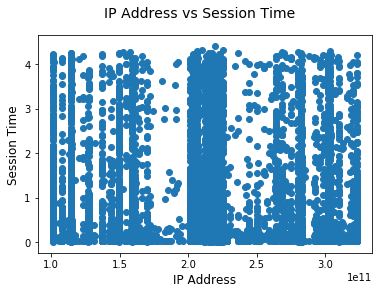

In [15]:
# Plot to see the distribution of IP addresses with session times
fig = pyplot.figure()
pyplot.scatter(df_sess['client_ip_flat'], df_sess['sess_time'])
fig.suptitle('IP Address vs Session Time', fontsize=14)
pyplot.xlabel('IP Address', fontsize=12)
pyplot.ylabel('Session Time', fontsize=12)
pyplot.show()

#### There are no outliers observed from this plot, so no further action needed about out of bound data points. 

#### Here I am using a binary classification to separate the users who spent less than 20 seconds (probably the non-productive users) and those who spent more than 20 seconds.

In [17]:
# Apply log transformation for normal distribution of IP addresses
ip_log = np.log(list(map(float, df_sess['client_ip_flat'])))

# Normalize transformed IP addresses, as they are in the large range
scaler = MinMaxScaler()
ip_scale = scaler.fit_transform(ip_log.reshape(-1, 1))  

# Binary labels
sess_label = df_sess['sess_class']

# One hot encoding of IP Address
# new_data = pd.get_dummies(df_sess['client_ip_flat'])   

# Strip the last 3 digits of IP Address
# new_data = df_sess['client_ip_flat'].floordiv(1000)[:, None]

# Strip the first 3 digits of the IP Address
# new_data = divmod(df_sess['client_ip_flat'], 1000000000)[1][:, None]

# Split the data into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(ip_scale, sess_label, test_size=0.20, random_state=0)

In [18]:
# Function for train and test classifiers
def train_test_classifier(clf, X_train, y_train, X_test, y_test):
    # Train the classifier
    clf.fit(X_train, y_train)
    # Predict on the test data
    predict = clf.predict(X_test)
    # Report the chosen metric
    fbeta = fbeta_score(y_test, predict, beta=1) * 100
    return fbeta

In [19]:
# Initialize the Gradient Boosting Classifier
clf = GradientBoostingClassifier(random_state=0)
# Call the function to train and test the classifier
fscore = train_test_classifier(clf, X_train, y_train, X_test, y_test)
# Report the metric
print('The fbeta score is {:.2f}%'.format(fscore))

The fbeta score is 58.50%


In [21]:
# Initialize the Logistic Regression Classifier
clf = LogisticRegression(random_state=0)
# Call the function to train and test the classifier
fscore = train_test_classifier(clf, X_train, y_train, X_test, y_test)
# Report the metric
print('The fbeta score is {:.2f}%'.format(fscore))

The fbeta score is 66.85%


In [22]:
# Initialize the Support Vector Classifier
clf = SVC(kernel='rbf', C=100, random_state=0)
# Call the function to train and test the classifier
fscore = train_test_classifier(clf, X_train, y_train, X_test, y_test)
# Report the metric
print('The fbeta score is {:.2f}%'.format(fscore))

The fbeta score is 66.85%


## Predict number of unique URLs against IP addresses

#### The below model is a simple model built on two features, as I am running this model on a small sample of data. Otherwise the features like "Session Start Time" and "Server Response Time" influence the user behaviour on how many pages (URLs) they visit on the site, but it needs large amount of data to verify this behaviour. It is discussed in detail in the document.

In [23]:
# Transforming IP address in the unique URL dataframe by calling the function
df_sess_uni_url_count['client_ip_flat'] = ""
for i, ip in enumerate(df_sess_uni_url_count['client_ip']):
    df_sess_uni_url_count['client_ip_flat'][i] = transform_ip(ip)

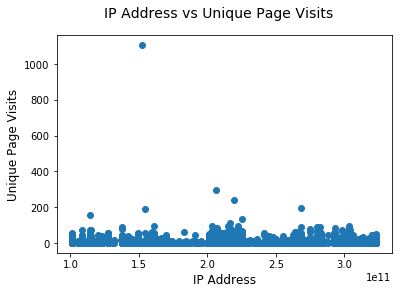

In [24]:
# Plot to see the distribution of IP addresses with unique page visits
fig = pyplot.figure()
pyplot.scatter(df_sess_uni_url_count['client_ip_flat'], df_sess_uni_url_count['uni_url_count'])
fig.suptitle('IP Address vs Unique Page Visits', fontsize=14)
pyplot.xlabel('IP Address', fontsize=12)
pyplot.ylabel('Unique Page Visits', fontsize=12)
pyplot.show()

#### There are outliers in the upper quartile range, so find the data points and remove extreme outliers only, to avoid losing important training data.

In [40]:
# Copy the dataframe to remove the outliers
df_url_count_out = df_sess_uni_url_count.copy()

# Find the outliers in the upper quartile of the number of urls
q75 = np.percentile((df_url_count_out['uni_url_count']), 75)
    
# Interquartile range for outlier
iqr = 11 * q75       
        
# Find the indices for outliers
out  = df_url_count_out.index[~((df_url_count_out['uni_url_count'] <= q75 + iqr))]
display(df_url_count_out.uni_url_count[out])

16       159
75        97
101     1104
149      295
157      111
233      190
259      238
610      134
2855     195
2961      97
Name: uni_url_count, dtype: int64

In [41]:
# Read the indexes of the outliers above 100 page hits
out_remove = [16, 101, 149, 157, 233, 259, 610, 2855]

# Remove the outliers with the url count more than 100
df_url_count_out = df_url_count_out.drop(df_url_count_out.index[out_remove]).reset_index(drop = True)

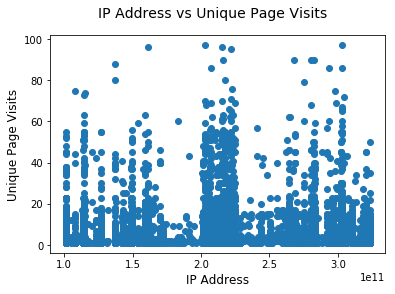

In [42]:
# Distribution of data points after removing the outliers
fig = pyplot.figure()
pyplot.scatter(df_url_count_out['client_ip_flat'], df_url_count_out['uni_url_count'])
fig.suptitle('IP Address vs Unique Page Visits', fontsize=14)
pyplot.xlabel('IP Address', fontsize=12)
pyplot.ylabel('Unique Page Visits', fontsize=12)
pyplot.show()

#### Here I am using multi-class classification with four different classes. 
#### Number of unique page hits below 25 is considered class 1
#### Number of unique page hits between 25 and 50 is considered class 2
#### Number of unique page hits between 50 and 75 is considered class 3
#### Number of unique page hits above 75 is considered class 4

In [44]:
# Classify the labels based on the number of page hits
df_url_count_out['count_label'] = ""
df_url_count_out.loc[df_url_count_out.uni_url_count < 25, 'count_label'] = 1
df_url_count_out.loc[(25 <= df_url_count_out.uni_url_count) & (df_url_count_out.uni_url_count <= 50), 'count_label'] = 2
df_url_count_out.loc[(50 <= df_url_count_out.uni_url_count) & (df_url_count_out.uni_url_count <= 75), 'count_label'] = 3
df_url_count_out.loc[df_url_count_out.uni_url_count > 75, 'count_label'] = 4

In [53]:
# Normalize transformed IP addresses, as they are in large range of numbers
scaler = MinMaxScaler()
ip_scale = scaler.fit_transform(df_url_count_out['client_ip_flat'].values.reshape(-1, 1))

# Assign labels
sess_label = df_url_count_out['count_label'].astype(int)

# One hot encoding of IP Address
# new_data = pd.get_dummies(df_url_count_out['client_ip_flat'])   

# Strip the last 3 digits of IP Address
# new_data = df_url_count_out['client_ip_flat'].floordiv(1000)[:, None]

#Strip the first 3 digits of the IP Address
# new_data = divmod(df_url_count_out['client_ip_flat'], 1000000000)[1][:, None]

# Split the data into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(ip_scale, sess_label, test_size=0.20, random_state=0)

In [34]:
# Function for train and test classifiers
def train_test_classifier_acc(clf, X_train, y_train, X_test, y_test):
    # Train the classifier
    clf.fit(X_train, y_train)
    # Predict on the test data
    predict = clf.predict(X_test)
    # Report the chosen metric
    accuracy = accuracy_score(y_test, predict) * 100
    return accuracy

In [54]:
# Initialize the Logistic Regression Classifier
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0) 
# Call the function to train and test the classifier
accuracy = train_test_classifier_acc(clf, X_train, y_train, X_test, y_test)
# Report the metric
print('The accuracy score is {:.2f}%'.format(accuracy))

The accuracy score is 94.62%


In [55]:
# Initialize the Gradient Boosting Classifier
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
# Call the function to train and test the classifier
accuracy = train_test_classifier_acc(clf, X_train, y_train, X_test, y_test)
# Report the metric
print('The accuracy score is {:.2f}%'.format(accuracy))

The accuracy score is 94.10%


## Predict expected load in the next time period

In [63]:
# Copy the request date time and strip the milliseconds
df_time = pd.DataFrame({'request_time' : []})
df_time['request_time'] = df.index
df_time['request_time'] = df_time['request_time'].astype(str).str.split('.', 1).str[0].astype('datetime64[ns]')

# Group by request time to count the number of requests every second
df1 = pd.DataFrame({'count' : df_time.groupby(df_time.request_time).size()}).reset_index()

# Normalize the count to bring down the range of values
scaler = MinMaxScaler()
df1['count'] = scaler.fit_transform(df1['count'].values.reshape(-1, 1))

# set request time as the index
df1.set_index('request_time', inplace=True)

In [65]:
# Take a continuous stream of one hour of data
df2 = pd.DataFrame(df1.values[2416:3294])

# Prepare data to store the current number of requests and the previous number of requests
columns = [df2.shift(i) for i in range(1, 2)]
columns.append(df2)
df2 = pd.concat(columns, axis=1)

# Update any null values with zero
df2.fillna(0, inplace=True)

In [66]:
# Define the split for training (80%) and testing (20%) data sets
split_no = round(len(df2) * 0.8)

# Split the training and testing data in continuous blocks
train = df2.values[0:split_no]
test = df2.values[split_no:]

# Prepare the data, as needed by the model
train = train.reshape(train.shape[0], train.shape[1])
test = test.reshape(test.shape[0], test.shape[1])

# Reshape the training data
X_train, y_train = train[:, 0:-1], train[:, -1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [67]:
# Build the model
model = Sequential()

# Define first LSTM layer and add a drop out of 20 percent
# return_sequence true means this layers output is fed into next layer
model.add(LSTM(1, input_shape=(None, 1), return_sequences=True))
model.add(Dropout(0.2))

# Define second LSTM layer and add dropout of 20 percent for this layer
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer and apply activation function
model.add(Dense(units=1))
model.add(Activation('linear'))

# Compile the model with loss function - Mean Squared Error and Optimizer - Gradient Descent
model.compile(loss='mse', optimizer='rmsprop')

In [68]:
# Train the model
model.fit(X_train, y_train, batch_size=128, epochs=150, validation_split=0.1, shuffle=False)

Train on 631 samples, validate on 71 samples
Epoch 1/150
631/631 [==============================] - 5s - loss: 0.1429 - val_loss: 0.1162
Epoch 2/150
631/631 [==============================] - 0s - loss: 0.1171 - val_loss: 0.0950
Epoch 3/150
631/631 [==============================] - 0s - loss: 0.0988 - val_loss: 0.0773
Epoch 4/150
631/631 [==============================] - 0s - loss: 0.0828 - val_loss: 0.0618
Epoch 5/150
631/631 [==============================] - 0s - loss: 0.0695 - val_loss: 0.0483
Epoch 6/150
631/631 [==============================] - 0s - loss: 0.0576 - val_loss: 0.0367
Epoch 7/150
631/631 [==============================] - 0s - loss: 0.0480 - val_loss: 0.0271
Epoch 8/150
631/631 [==============================] - 0s - loss: 0.0395 - val_loss: 0.0193
Epoch 9/150
631/631 [==============================] - 0s - loss: 0.0340 - val_loss: 0.0135
Epoch 10/150
631/631 [==============================] - 0s - loss: 0.0292 - val_loss: 0.0092
Epoch 11/150
631/631 [============

In [69]:
# Reshape the testing data
X_test, y_test = test[:, 0:-1], test[:, -1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Predict on the test data using trained model
predicted = model.predict(X_test)

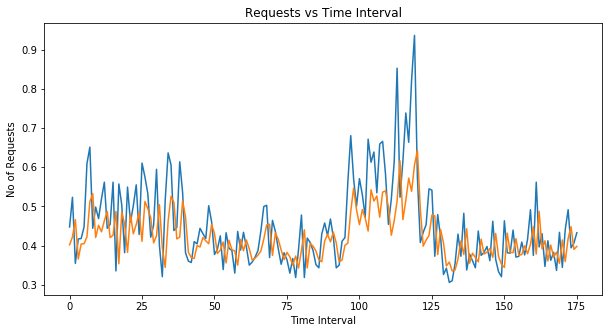

In [73]:
# Plot the actual and predicted test data
fig = pyplot.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(y_test, label='Actual')
ax.plot(predicted, label='Predicted')
ax.set_xlabel('Time Interval')
ax.set_ylabel('No of Requests')
ax.set_title('Requests vs Time Interval')
pyplot.show()